In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import pandas as pd
from tqdm import tqdm

from scipy.stats import multivariate_normal, invwishart, matrix_normal

In [52]:
def plot_latent_state_dynamic(X1, X2, A, b, player_code, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    x_star = np.stack([np.dot(np.linalg.inv(np.eye(2, 2) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 6*K))
    colors = ["g", "b", "r", "c", "m"]
    
    x_c = player_code*2 - 2
    y_c = player_code*2 - 1

    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        if show_fixed_point:
            ax[k].scatter(x_star[k][0], x_star[k][1])

        if show_states:
            #c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else i for i in z]
            c = [colors[k] if i == k else "grey" for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, x_c], y[t:t+2, y_c], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, x_c], y[t+1, x_c]])
                arr_mean_y2 = np.mean([y[t, y_c], y[t+1, y_c]])
                dy1 = y[t+1, x_c] - y[t, x_c]
                dy2 = y[t+1, y_c] - y[t, y_c]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
            '''
            # code to add the arrows in the middle of the lines (fix head_width if needed)
            for t in range(y.shape[0]-1):
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = 'navy')
            '''
            

In [3]:
# function to transform values in [0,1] in values in [-1,1]
def normalize_coordinates(y):
    y1_norm = ((y[:, 0] - 0.5)*2).reshape(-1, 1)
    y2_norm = (-(y[:, 1] - 0.5)*2).reshape(-1, 1)
    y_norm = np.concatenate([y1_norm, y2_norm], axis = 1)
    return y_norm

## Collecting data

In [4]:
dataset = pd.read_csv("Datasets/match1.csv")
dataset_1 = dataset.where(dataset.period_id == 1) # select only first half of the match
dataset_1

,Unnamed: 0,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,home_11_x,...,home_13_d,home_13_s,away_28_x,away_28_y,away_28_d,away_28_s,home_14_x,home_14_y,home_14_d,home_14_s
0,0.0,1.0,0.0,1.0,NaN,NaN,0.45472,0.61291,NaN,0.00082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.2,6.0,NaN,NaN,0.55677,0.61091,NaN,0.00140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,0.4,11.0,NaN,NaN,0.56504,0.69395,NaN,0.00085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,0.6,16.0,NaN,NaN,0.57330,0.77700,NaN,0.00065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.0,0.8,21.0,NaN,NaN,0.57247,0.79726,NaN,0.00066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
player = "home_" + str(1) # terzino sinistro
fh = dataset_1[[player + "_x", player + "_y"]].to_numpy()
fh = fh[np.isnan(fh) == False].reshape(-1, 2)
y = normalize_coordinates(fh)
n_timesteps = y.shape[0]

for i in range(1, 4):
    player = "home_" + str(i+1) # terzino sinistro
    fh = dataset_1[[player + "_x", player + "_y"]].to_numpy()
    fh = fh[np.isnan(fh) == False].reshape(-1, 2)

    if fh.shape[0] < n_timesteps:
        y = y[:fh.shape[0]]
        n_timesteps = fh.shape[0]
    else:
        fh = fh[:n_timesteps]
    
    fh = normalize_coordinates(fh)
    y = np.concatenate([y, fh], axis = 1)    

print(y.shape)

downsampling = 5 # how often data is taken from the trajectory (to reduce number of points)
y = y[::downsampling]
print(y.shape)



(9342, 8)
(1869, 8)


(-1.0, 1.0)

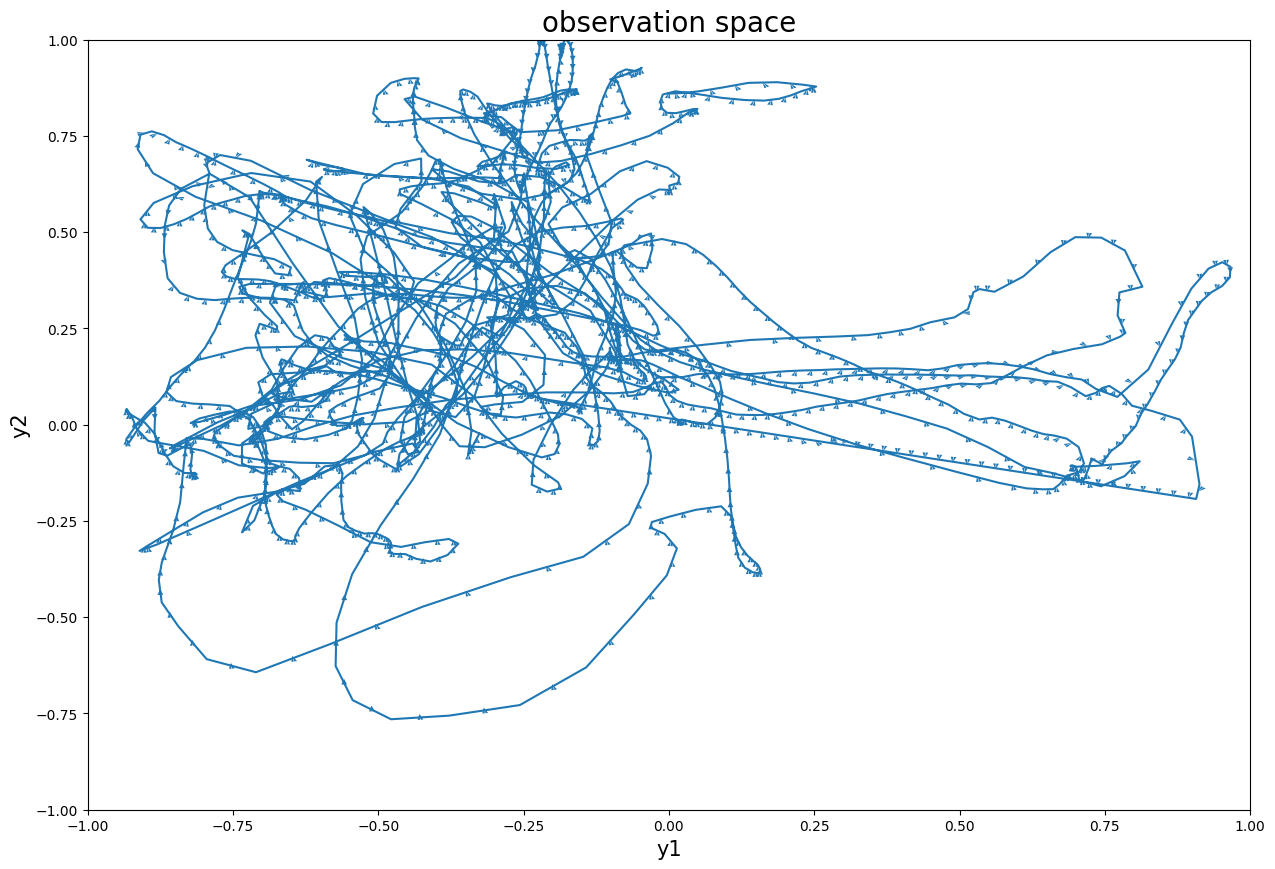

In [114]:
plt.rcParams["figure.figsize"] = (15,10)

player_code = 2

x_c = 2*player_code - 2
y_c = 2*player_code - 1

plt.plot(y[:, x_c], y[:, y_c])

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, x_c], y[t+1, x_c]])
    arr_mean_y2 = np.mean([y[t, y_c], y[t+1, y_c]])
    dy1 = y[t+1, x_c] - y[t, x_c]
    dy2 = y[t+1, 1] - y[t, y_c]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [115]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [120]:
T = y.shape[0] # number of time steps
N = 8 # observation dim
K = 5 # latent dim

L = 20 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

S = 0.01*np.eye(N, N) # 1 meter in each direction
nu = N
C = 0.1*np.random.randn(N, N+1)
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0][:, :, 0] = 1*np.random.randn(K, N)
A_hat_inf[0][:, :, 1:] = 1*np.random.randn(K, N, N)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([0.01*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[ 0.37144279 -0.1894378  -1.14518468  0.48115318 -1.74253969
   -0.76334195  0.44435125 -0.04534298  1.51548153]
  [-0.4172479   0.59457735  0.49474041  1.34492801  0.60420292
    1.89050567  0.62068568 -0.95988426 -1.72898602]
  [-0.2186623   0.76293038 -0.20532842 -0.30913951  0.33985519
    0.47835583 -0.54716663 -0.12074126  1.24817594]
  [ 0.77262746 -0.2248376   1.25309721 -1.3468202  -1.28928843
   -0.22985089 -1.04908822 -0.59161469 -0.66250806]
  [ 0.99501345 -0.79514855  1.0505031   1.37989383 -0.74315612
    0.25646042 -1.21154529  0.37684178 -0.69639294]
  [ 1.29159438  0.68288259  1.35374769 -0.05550993 -1.20833569
   -1.1033653  -0.45369819  2.15795299  0.57679804]
  [ 0.94048657  0.98047048 -0.77228707  0.41662151  0.06804169
    0.8820225   0.82266865 -1.19581237  1.38760393]
  [ 0.3039102  -0.01092724  1.01302391  0.63204533 -0.31122201
   -1.60187195 -0.72021194  0.28100542 -0.45260589]]

 [[-0.59114214  0.38975354 -0.78976251 -1.83287431 -0.03108359
   -1.29983707 

In [121]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

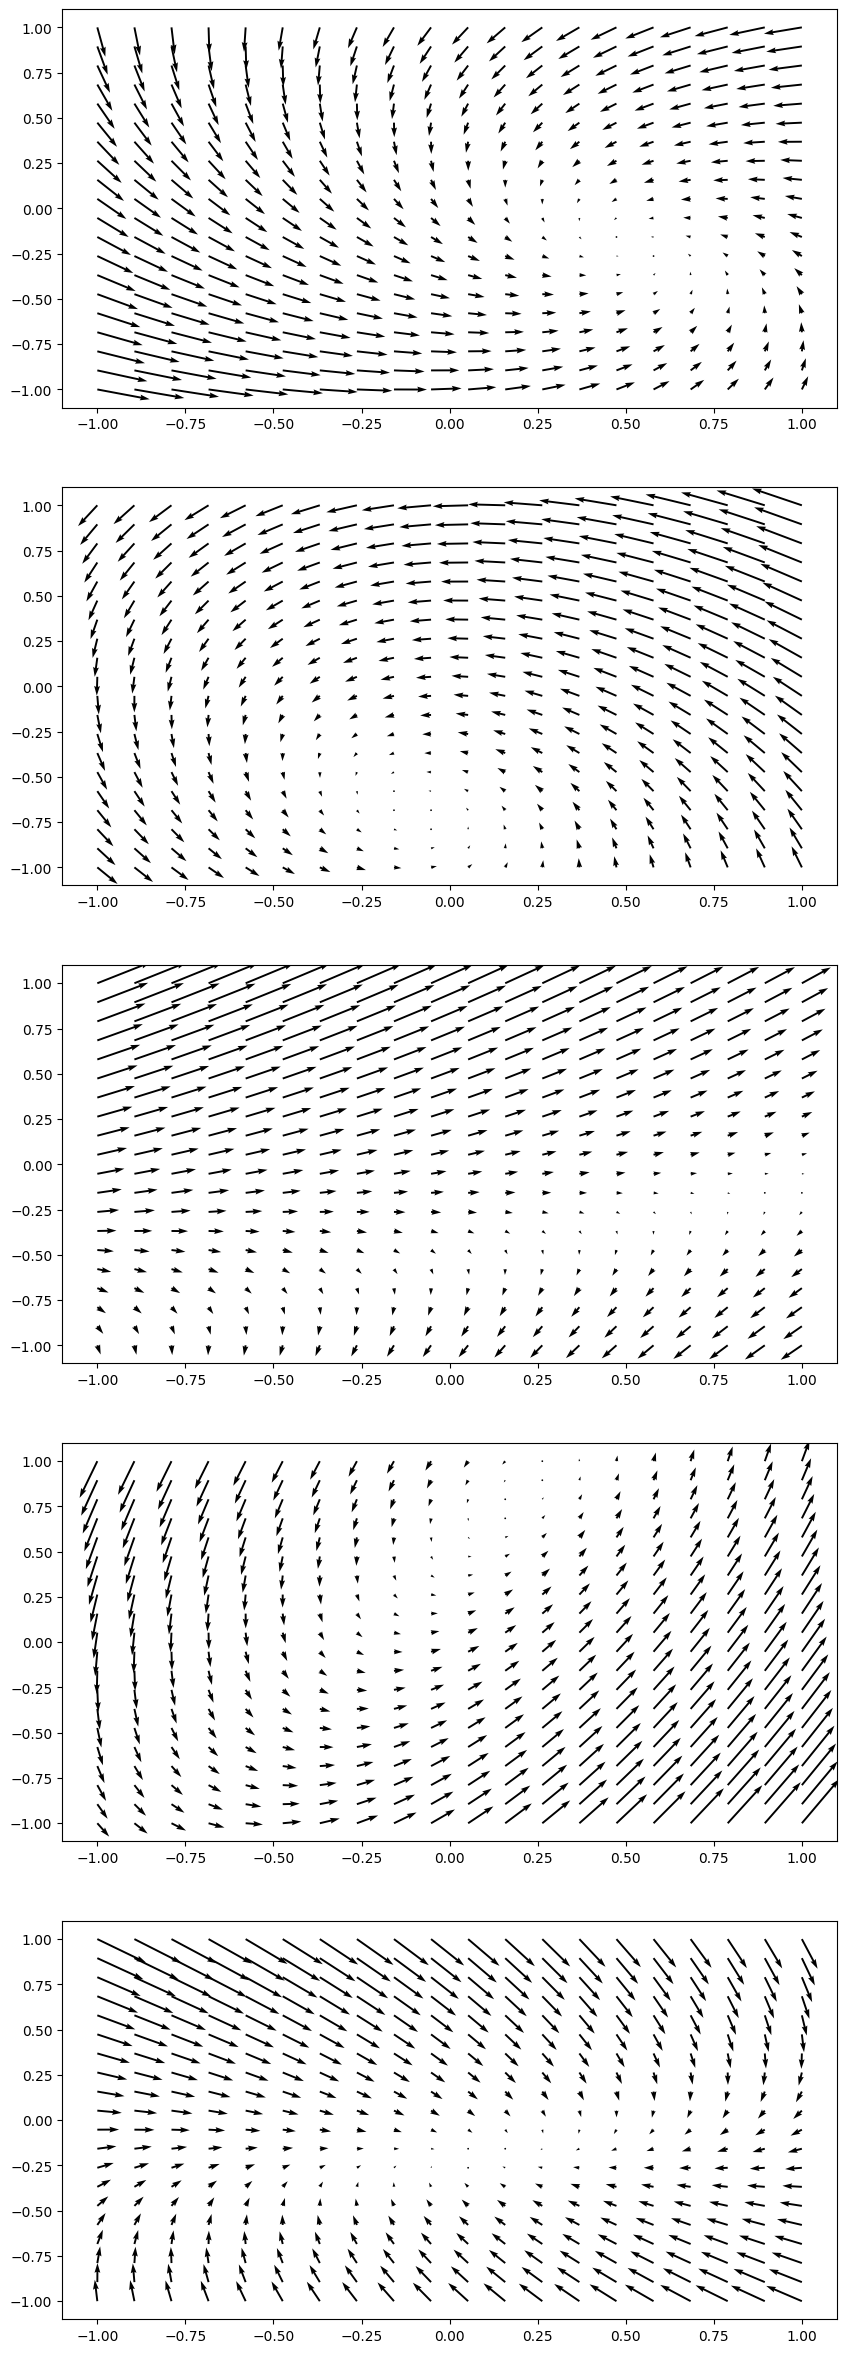

In [122]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf[:, :2, :2], b_inf[:, :2], player_code = 1, show_fixed_point = False)

In [83]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):

    log_m = [np.array([0]*K)] # list of log messages, the first one has all zeros

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]

            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # insert message in the list

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [84]:
### my version of sampling z_t

def myconditionals(M_inf_l, A_hat_inf_l, Q_inf_l, z_inf_prec):

    # discrete conditional distribution P(z_t|...) at each time 1,...,T
    p_z = np.zeros((T, K))
    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # P(z_1|...)
    for k in range(K):
        log_p_z[0, k] = np.log(M_inf_l[z_inf_prec[1], k])
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # P(z_t|...) for t in 2:T-1
    for t in range(1, T-1):
        for k in range(K):
            y_hat = np.concatenate([np.array([1]), y[t-1]])
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = rv.logpdf(x) + np.log(M_inf_l[z_inf_prec[t+1], k] * M_inf_l[k, z_inf_l[t-1]])
            #print(rv.pdf(x))

        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    # P(z_T|...)        
    for k in range(K):
        y_hat = np.concatenate([np.array([1]), y[T-2]])
        rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
        x = y[T-1] - np.dot(A_hat_inf_l[k], y_hat)
        log_p_z[T-1, k] = rv.logpdf(x) + np.log(M_inf_l[k, z_inf_l[T-2]])
    log_p_z[T-1] = log_p_z[T-1] - logsumexp(log_p_z[T-1])
    z_inf_l[T-1] = np.random.choice(K, p = np.exp(log_p_z[T-1]))

    return z_inf_l


In [123]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in tqdm(range(L-1)):
    
    #print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)

100%|██████████| 19/19 [07:17<00:00, 23.02s/it]


In [124]:
def compute_mean_z(inferred_z):
    # mean_z of a certain number of samples, following majority rule
    mean_z = np.zeros(T).astype('int')
    for t in range(T):
        mean_z[t] = np.argmax(np.bincount(inferred_z[:, t]))
    return mean_z

In [125]:
# analysing inferred z at different epochs of the gibbs sampler
z_mean = compute_mean_z(z_inf[L//2:])
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(z_mean)
#print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[L//2:], return_counts=True)
print(dict(zip(unique, counts)))

[4 2 4 ... 3 3 4]
[0 1 1 ... 0 0 0]
[4 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
{0: 7526, 1: 5841, 2: 571, 3: 3476, 4: 1276}


In [126]:
used_states = []
for l in range(L):
    unique, counts = np.unique(z_inf[l], return_counts=True)
    used_states.append(unique)

print(used_states)

[array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4])]


In [127]:
M_mean = np.mean(M_inf[L//2:], axis = 0) # best estimate for M
print(M_mean)
eigw_inf, eigv_inf = np.linalg.eig(M_mean.T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0])) # stationary distribution of Prob(z)

[[0.93519972 0.02763536 0.00830888 0.02292874 0.00592729]
 [0.05146368 0.89062746 0.00415331 0.04604278 0.00771277]
 [0.01760789 0.11205461 0.82532051 0.03569226 0.00932474]
 [0.03714059 0.05805596 0.00420393 0.85705515 0.04354438]
 [0.06118133 0.07973016 0.02081113 0.02573186 0.81254552]]
[0.41441747 0.29318442 0.03939913 0.18329427 0.06970471]


In [128]:
A_hat_mean = np.mean(A_hat_inf[L//2:], axis = 0) # best estimate for A_hat
print(A_hat_mean)

[[[ 1.90468436e-02  1.00785737e+00 -7.66370765e-03 -3.08747115e-02
   -1.98265078e-02  4.76144619e-03  4.90153249e-04  1.28443238e-02
    6.79004718e-03]
  [-6.07791867e-03  6.85453456e-03  9.79537650e-01  3.57582265e-03
    1.72204669e-02  1.24577516e-03 -3.93144931e-04 -4.97871582e-02
   -2.28337575e-03]
  [ 1.20379115e-02  1.85240580e-02  1.54453392e-02  9.47480256e-01
   -2.99575685e-02  1.99245016e-02 -1.22506447e-03  2.10287974e-02
    4.42006382e-03]
  [ 3.71950200e-03  1.21702857e-03 -1.32585730e-02  5.44944145e-03
    1.00867333e+00 -2.12934949e-02 -5.64855342e-03  5.35042782e-03
    1.15534145e-02]
  [ 2.15466685e-02  9.62960308e-03  6.36684950e-03 -2.55533464e-02
   -3.15179905e-02  9.91306469e-01  1.99321807e-03  3.59934293e-02
    5.96226882e-03]
  [-5.59452263e-03 -1.49608360e-02  3.34934637e-03  1.71939181e-02
    7.61877480e-03 -3.61120604e-03  1.00846080e+00  3.50127844e-02
   -1.77291379e-02]
  [ 2.86164675e-03  8.00410603e-03  7.42874790e-03 -1.73095237e-02
   -1.525

In [129]:
Q_mean = np.mean(Q_inf, axis = 0) # best estimate for Q
for k in range(K):
    print(Q_mean[k])
    eigw_q, _ = np.linalg.eig(Q_mean[k]) # eigenvalues of Q_k
    print(eigw_q, "\n")

[[ 6.74036895e-04  6.21699793e-06  1.15013888e-04  2.46117347e-05
   1.33470582e-04  1.54574387e-06  7.64701308e-05 -7.92037991e-06]
 [ 6.21699793e-06  7.19892710e-04 -1.68375864e-05  8.15523543e-05
  -2.23992917e-05  4.03954057e-05 -8.12480599e-06  2.17946292e-06]
 [ 1.15013888e-04 -1.68375864e-05  7.15649762e-04  8.35184553e-06
   1.26969292e-04 -8.67014408e-06  7.49542733e-05  8.31302472e-07]
 [ 2.46117347e-05  8.15523543e-05  8.35184553e-06  7.62678430e-04
   1.12226114e-05  7.18003033e-05  1.78702213e-05  2.05583668e-05]
 [ 1.33470582e-04 -2.23992917e-05  1.26969292e-04  1.12226114e-05
   7.46678055e-04 -1.53848327e-05  1.04266905e-04  9.31954321e-06]
 [ 1.54574387e-06  4.03954057e-05 -8.67014408e-06  7.18003033e-05
  -1.53848327e-05  9.50904131e-04 -1.89660824e-05  1.45443446e-04]
 [ 7.64701308e-05 -8.12480599e-06  7.49542733e-05  1.78702213e-05
   1.04266905e-04 -1.89660824e-05  6.67346881e-04 -1.67372189e-05]
 [-7.92037991e-06  2.17946292e-06  8.31302472e-07  2.05583668e-05
   

In [132]:
# best estimate for A_hat decomposition in A and b, in order to plot the lds
player_code = 1
xc = player_code*2 - 2
yc = player_code*2
b_inf_av = A_hat_mean[:,xc:yc,0]
A_inf_av = A_hat_mean[:,xc:yc,(xc+1):(yc+1)]

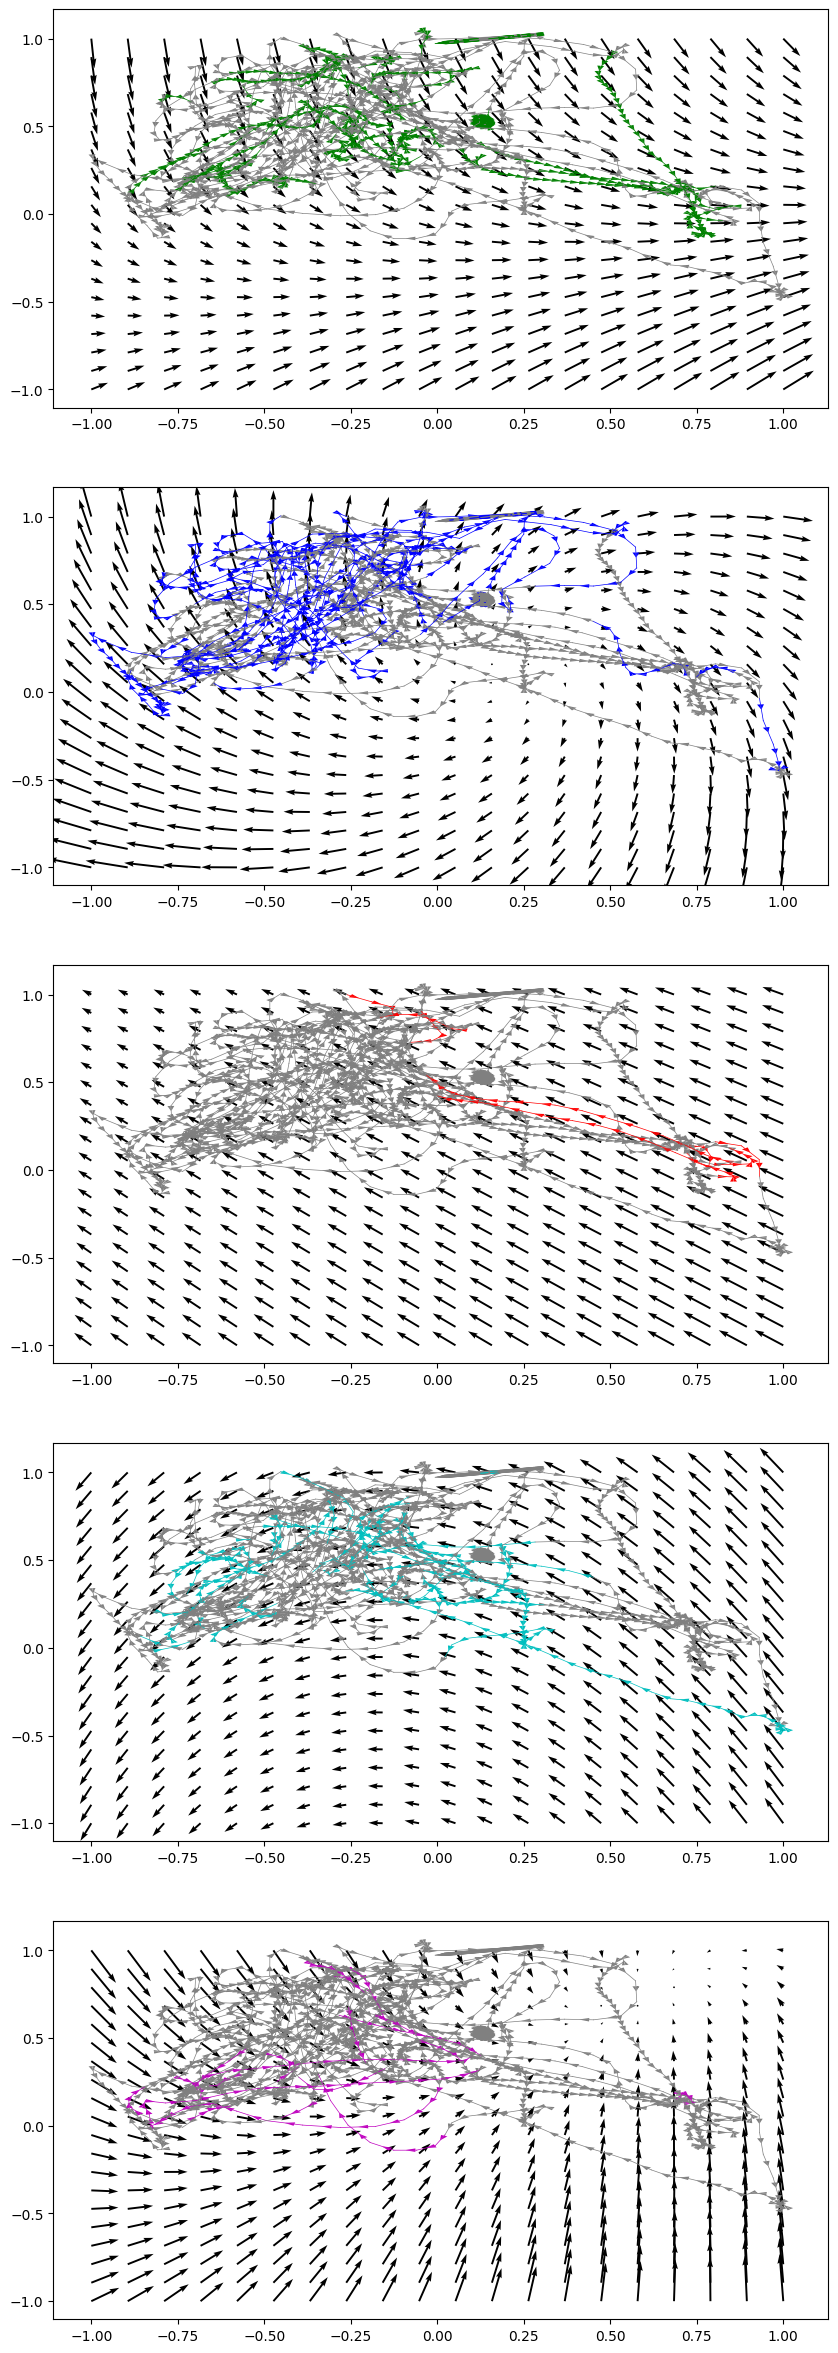

In [133]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, player_code = player_code, show_fixed_point = False, show_states = True, z = z_mean)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7418b957-40c0-4b8c-8b59-f82ba42a5a5a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>